In [8]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import logging

# Statistical analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
# Machine learning metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: Auto ARIMA (install with: pip install pmdarima)
try:
    from pmdarima import auto_arima
    AUTO_ARIMA_AVAILABLE = True
except ImportError:
    AUTO_ARIMA_AVAILABLE = False
    print("pmdarima not available. Manual SARIMA parameter selection will be used.")

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("All libraries imported successfully!")

All libraries imported successfully!


In [9]:


df_raw = pd.read_csv('solar_weather.csv')

print("Dataset Overview:")
print(f"Shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print("\nFirst few rows:")
df_raw.head()
# Check time column format to confirm 15-minute intervals
print(f"\nTime Column Analysis:")
if 'Time' in df_raw.columns:
    df_raw['Time'] = pd.to_datetime(df_raw['Time'])
    time_diffs = df_raw['Time'].diff().dropna()
    print(f"Time differences (first 10): {time_diffs.head(10)}")
    print(f"Most common time difference: {time_diffs.mode().iloc[0] if len(time_diffs.mode()) > 0 else 'N/A'}")
    
    # Confirm 15-minute intervals
    if time_diffs.mode().iloc[0] == pd.Timedelta('15 minutes'):
        print("Confirmed: Data has 15-minute intervals")
    else:
        print(f"Unexpected interval: {time_diffs.mode().iloc[0]}")
else:
    print("'Time' column not found")
# Data info
print("Data Info:")
df_raw.info()
# Basic statistics
print("Descriptive Statistics:")
df_raw.describe()

Dataset Overview:
Shape: (196776, 17)
Columns: ['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun', 'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type', 'hour', 'month']

First few rows:

Time Column Analysis:
Time differences (first 10): 1    0 days 00:15:00
2    0 days 00:15:00
3    0 days 00:15:00
4    0 days 00:15:00
5    0 days 00:15:00
6    0 days 00:15:00
7    0 days 00:15:00
8    0 days 00:15:00
9    0 days 00:15:00
10   0 days 00:15:00
Name: Time, dtype: timedelta64[ns]
Most common time difference: 0 days 00:15:00
Confirmed: Data has 15-minute intervals
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    196776 non-null  datetime64[ns]
 1   Energy delta[Wh]        19677

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
count,196776,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,2019-10-29 22:44:12.085620992,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,0.519962,211.721094,748.644347,0.265187,3.198398,11.498902,6.298329
min,2017-01-01 00:00:00,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,1.000000,0.000000,1.000000
25%,2018-06-02 10:26:15,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,0.000000,570.000000,0.000000,2.000000,5.000000,3.000000
50%,2019-10-28 20:52:30,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,1.000000,30.000000,765.000000,0.050000,4.000000,11.000000,6.000000
75%,2021-03-24 07:18:45,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,1.000000,390.000000,930.000000,0.530000,4.000000,17.000000,9.000000
max,2022-08-31 17:45:00,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1.000000,1020.000000,1020.000000,1.000000,5.000000,23.000000,12.000000
std,NaN,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,0.499603,273.902186,194.870208,0.329023,1.289939,6.921887,3.376066


In [10]:
def determine_seasonality(series, freq_hint=None):
    """Determine seasonality period based on data frequency"""
    if freq_hint:
        freq_str = freq_hint
    else:
        freq_str = pd.infer_freq(series.index)
    
    if freq_str is None:
        logging.warning("Could not infer frequency. Assuming hourly data (s=24)")
        return 24
    
    freq_mapping = {
        '15T': 96,    # 15-minute: 4 * 24 = 96
        '15min': 96,
        'H': 24,      # Hourly: 24
        '1H': 24,
        'D': 1,       # Daily: weekly seasonality
        '1D': 1
    }
    
    for pattern, s_value in freq_mapping.items():
        if pattern in str(freq_str):
            return s_value
    
    logging.warning(f"Unknown frequency {freq_str}. Defaulting to s=24")
    return 24

def prepare_time_series_data(df, time_col='Time', target_col='GHI', test_size=0.2):
    """Prepare data for classical time series analysis"""
    df_work = df.copy()
    
    # Convert time column to datetime
    if time_col in df_work.columns:
        df_work[time_col] = pd.to_datetime(df_work[time_col])
        df_work = df_work.set_index(time_col)
    elif not isinstance(df_work.index, pd.DatetimeIndex):
        raise ValueError(f"No '{time_col}' column found and index is not datetime")
    
    # Extract target series
    if target_col not in df_work.columns:
        raise ValueError(f"Target column '{target_col}' not found")
    
    series = df_work[target_col].copy()
    
    # Handle missing values
    print(f"Missing values before cleaning: {series.isnull().sum()}")
    series = series.ffill().bfill()
    print(f"Missing values after cleaning: {series.isnull().sum()}")
    
    # Remove any remaining NaN values
    series = series.dropna()
    
    # CRITICAL: Set frequency for 15-minute data to enable proper seasonality detection
    try:
        # Attempt to set frequency if data is regular 15-minute intervals
        series_with_freq = series.asfreq('15T')
        print("Successfully set frequency to 15T (15-minute intervals)")
        series = series_with_freq.ffill().bfill()  # Handle any NaNs introduced by asfreq
    except Exception as e:
        print(f"Could not set frequency automatically: {e}")
        print("   Proceeding with original series - will manually set seasonality")
    
    # Determine seasonality
    s = determine_seasonality(series)
    
    # MANUAL OVERRIDE for 15-minute data (most reliable approach)
    if s != 96:
        print(f"Detected seasonality {s} may be incorrect for 15-minute data")
        s = 96  # Force correct seasonality for 15-minute data
        print(f"Manually overriding seasonality to {s} (daily cycle for 15-min data)")
    
    # Train-test split
    split_point = int(len(series) * (1 - test_size))
    train_series = series[:split_point]
    test_series = series[split_point:]
    
    print(f"Data prepared successfully:")
    print(f"   Total samples: {len(series)}")
    print(f"   Training samples: {len(train_series)}")
    print(f"   Test samples: {len(test_series)}")
    print(f"   Seasonality period: {s}")
    print(f"   Data frequency: {series.index.freq or 'Not detected'}")
    
    return train_series, test_series, s

# Prepare the data
train_series, test_series, seasonality = prepare_time_series_data(
    df_raw, 
    time_col='Time', 
    target_col='GHI',
    test_size=0.2
)

Missing values before cleaning: 0
Missing values after cleaning: 0
Successfully set frequency to 15T (15-minute intervals)
Data prepared successfully:
   Total samples: 198600
   Training samples: 158880
   Test samples: 39720
   Seasonality period: 96
   Data frequency: <15 * Minutes>


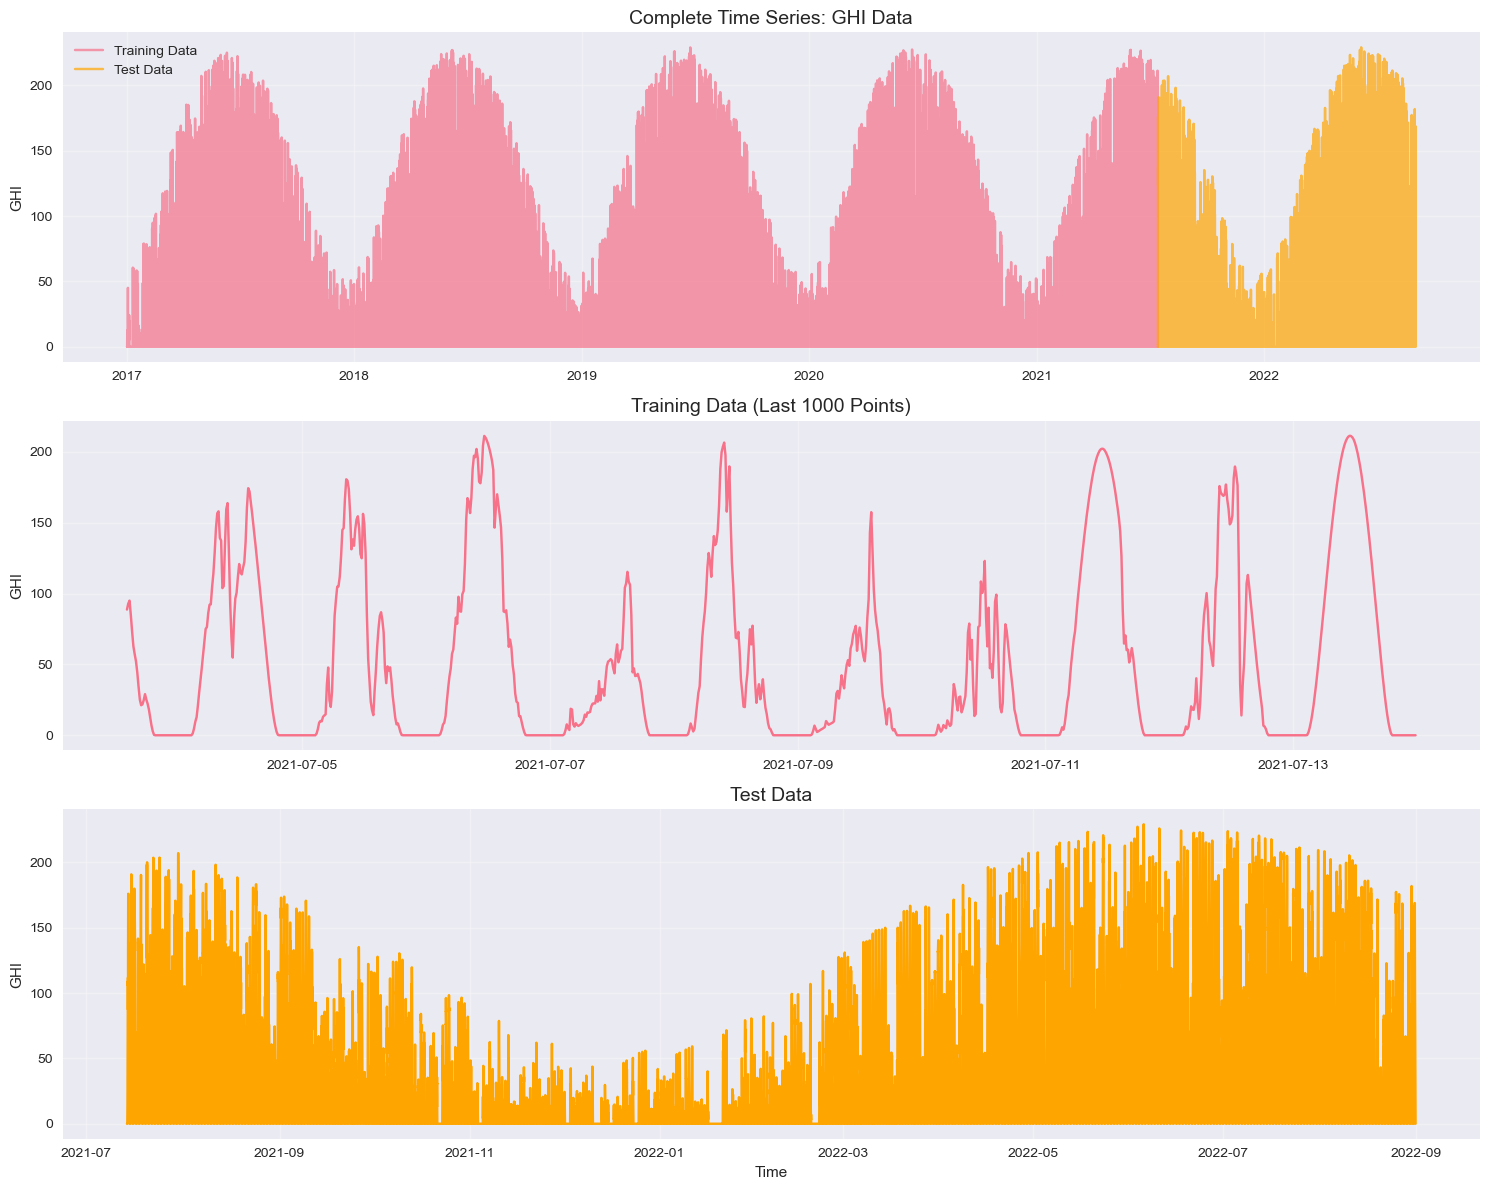

In [11]:
# Plot the full time series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Full series
axes[0].plot(train_series.index, train_series, alpha=0.7, label='Training Data')
axes[0].plot(test_series.index, test_series, alpha=0.7, label='Test Data', color='orange')
axes[0].set_title('Complete Time Series: GHI Data', fontsize=14)
axes[0].set_ylabel('GHI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training data detail
axes[1].plot(train_series.index[-1000:], train_series[-1000:])
axes[1].set_title('Training Data (Last 1000 Points)', fontsize=14)
axes[1].set_ylabel('GHI')
axes[1].grid(True, alpha=0.3)

# Test data detail
axes[2].plot(test_series.index, test_series, color='orange')
axes[2].set_title('Test Data', fontsize=14)
axes[2].set_ylabel('GHI')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

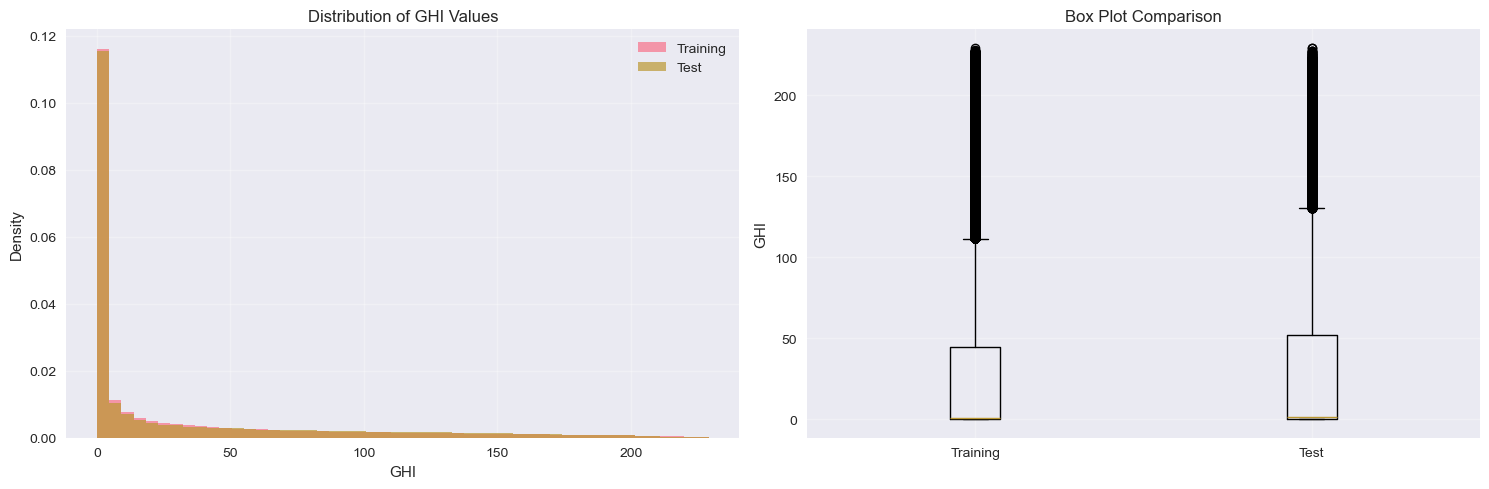

In [12]:
# Distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train_series, bins=50, alpha=0.7, density=True, label='Training')
axes[0].hist(test_series, bins=50, alpha=0.7, density=True, label='Test')
axes[0].set_title('Distribution of GHI Values')
axes[0].set_xlabel('GHI')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_for_box = [train_series.values, test_series.values]
axes[1].boxplot(data_for_box, labels=['Training', 'Test'])
axes[1].set_title('Box Plot Comparison')
axes[1].set_ylabel('GHI')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Performing seasonal decomposition...


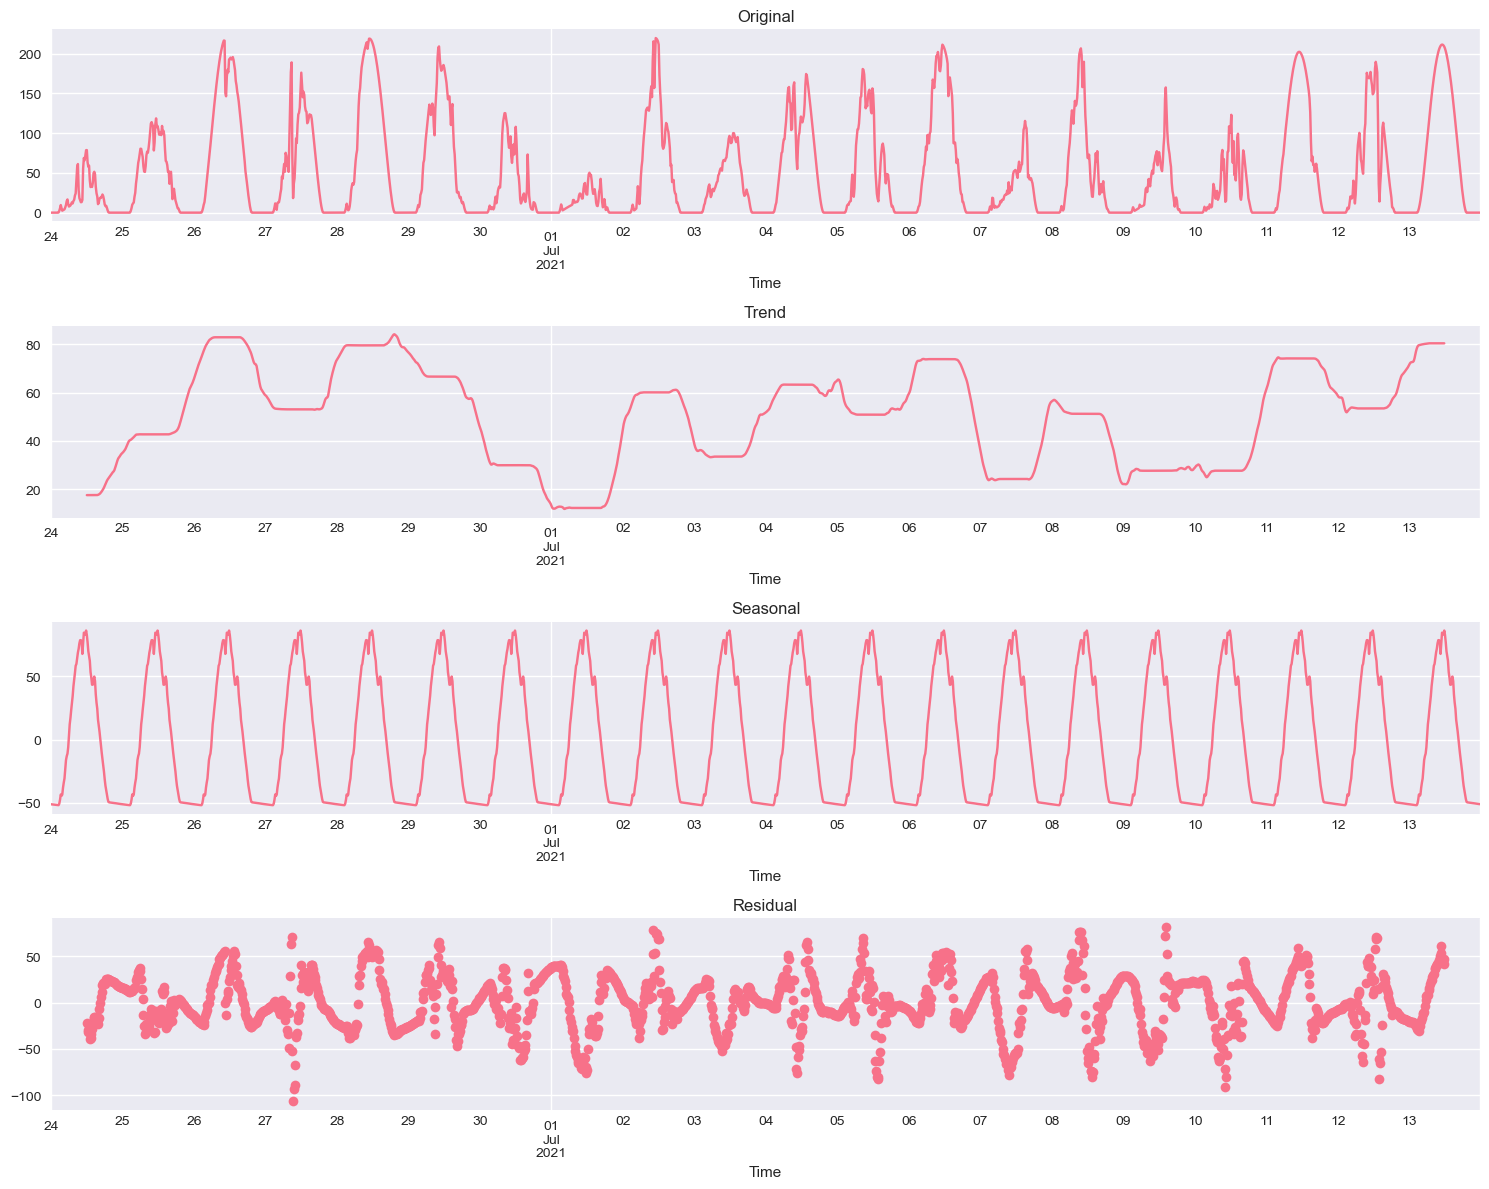

Seasonal decomposition completed


In [16]:
# Perform seasonal decomposition
print("Performing seasonal decomposition...")

try:
    # Use a subset for decomposition if data is too large
    decomp_data = train_series[-min(len(train_series), seasonality * 20):]
    
    decomposition = seasonal_decompose(
        decomp_data, 
        model='additive', 
        period=seasonality
    )
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual', marker="o", linestyle="none")
    
    plt.tight_layout()
    plt.show()
    
    print("Seasonal decomposition completed")
    
except Exception as e:
    print(f"Could not perform seasonal decomposition: {e}")

In [14]:
def check_stationarity(series, name="Series", alpha=0.05):
    """Comprehensive stationarity testing"""
    print(f"\nStationarity Analysis for {name}")
    print("=" * 50)
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(series.dropna())
    print(f"ADF Test:")
    print(f"  Statistic: {adf_result[0]:.6f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Critical Values: {adf_result[4]}")
    
    adf_stationary = adf_result[1] <= alpha
    print(f"  Result: {'Stationary' if adf_stationary else 'Non-stationary'}")
    
    # KPSS test
    try:
        kpss_result = kpss(series.dropna(), regression='c')
        print(f"\nKPSS Test:")
        print(f"  Statistic: {kpss_result[0]:.6f}")
        print(f"  p-value: {kpss_result[1]:.6f}")
        print(f"  Critical Values: {kpss_result[3]}")
        
        kpss_stationary = kpss_result[1] > alpha
        print(f"  Result: {'Stationary' if kpss_stationary else 'Non-stationary'}")
        
        # Consensus
        if adf_stationary and kpss_stationary:
            consensus = "Stationary"
        elif not adf_stationary and not kpss_stationary:
            consensus = "Non-stationary"
        else:
            consensus = "Inconclusive"
            
        print(f"\nConsensus: {consensus}")
        
    except Exception as e:
        print(f"KPSS test failed: {e}")
        consensus = "Stationary" if adf_stationary else "Non-stationary"
        print(f"Based on ADF only: {consensus}")
    
    return adf_stationary

# Test original series
is_stationary = check_stationarity(train_series, "Original Training Series")


Stationarity Analysis for Original Training Series
ADF Test:
  Statistic: -17.746055
  p-value: 0.000000
  Critical Values: {'1%': -3.4303911793587427, '5%': -2.8615582007056766, '10%': -2.566779687585805}
  Result: Stationary

KPSS Test:
  Statistic: 0.817979
  p-value: 0.010000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Result: Non-stationary

Consensus: Inconclusive


In [19]:
# If non-stationary, explore differencing
if not is_stationary:
    print("\nExploring differencing options...")
    
    # First difference
    train_diff1 = train_series.diff().dropna()
    is_stationary_diff1 = check_stationarity(train_diff1, "First Differenced Series")
    
    # Seasonal difference
    if len(train_series) > seasonality:
        train_seasonal_diff = train_series.diff(seasonality).dropna()
        is_stationary_seasonal = check_stationarity(train_seasonal_diff, "Seasonal Differenced Series")
        
        # Combined differencing
        train_combined_diff = train_series.diff().diff(seasonality).dropna()
        if len(train_combined_diff) > 50:
            is_stationary_combined = check_stationarity(train_combined_diff, "Combined Differenced Series")
    
    # Plot differenced series
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original
    axes[0,0].plot(train_series.index[-500:], train_series[-500:])
    axes[0,0].set_title('Original Series (Last 500 points)')
    axes[0,0].grid(True, alpha=0.3)
    
    # First difference
    axes[0,1].plot(train_diff1.index[-500:], train_diff1[-500:])
    axes[0,1].set_title('First Differenced Series')
    axes[0,1].grid(True, alpha=0.3)
    
    # Seasonal difference
    if len(train_series) > seasonality:
        axes[1,0].plot(train_seasonal_diff.index[-500:], train_seasonal_diff[-500:])
        axes[1,0].set_title('Seasonal Differenced Series')
        axes[1,0].grid(True, alpha=0.3)
        
        # Combined
        axes[1,1].plot(train_combined_diff.index[-500:], train_combined_diff[-500:])
        axes[1,1].set_title('Combined Differenced Series')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

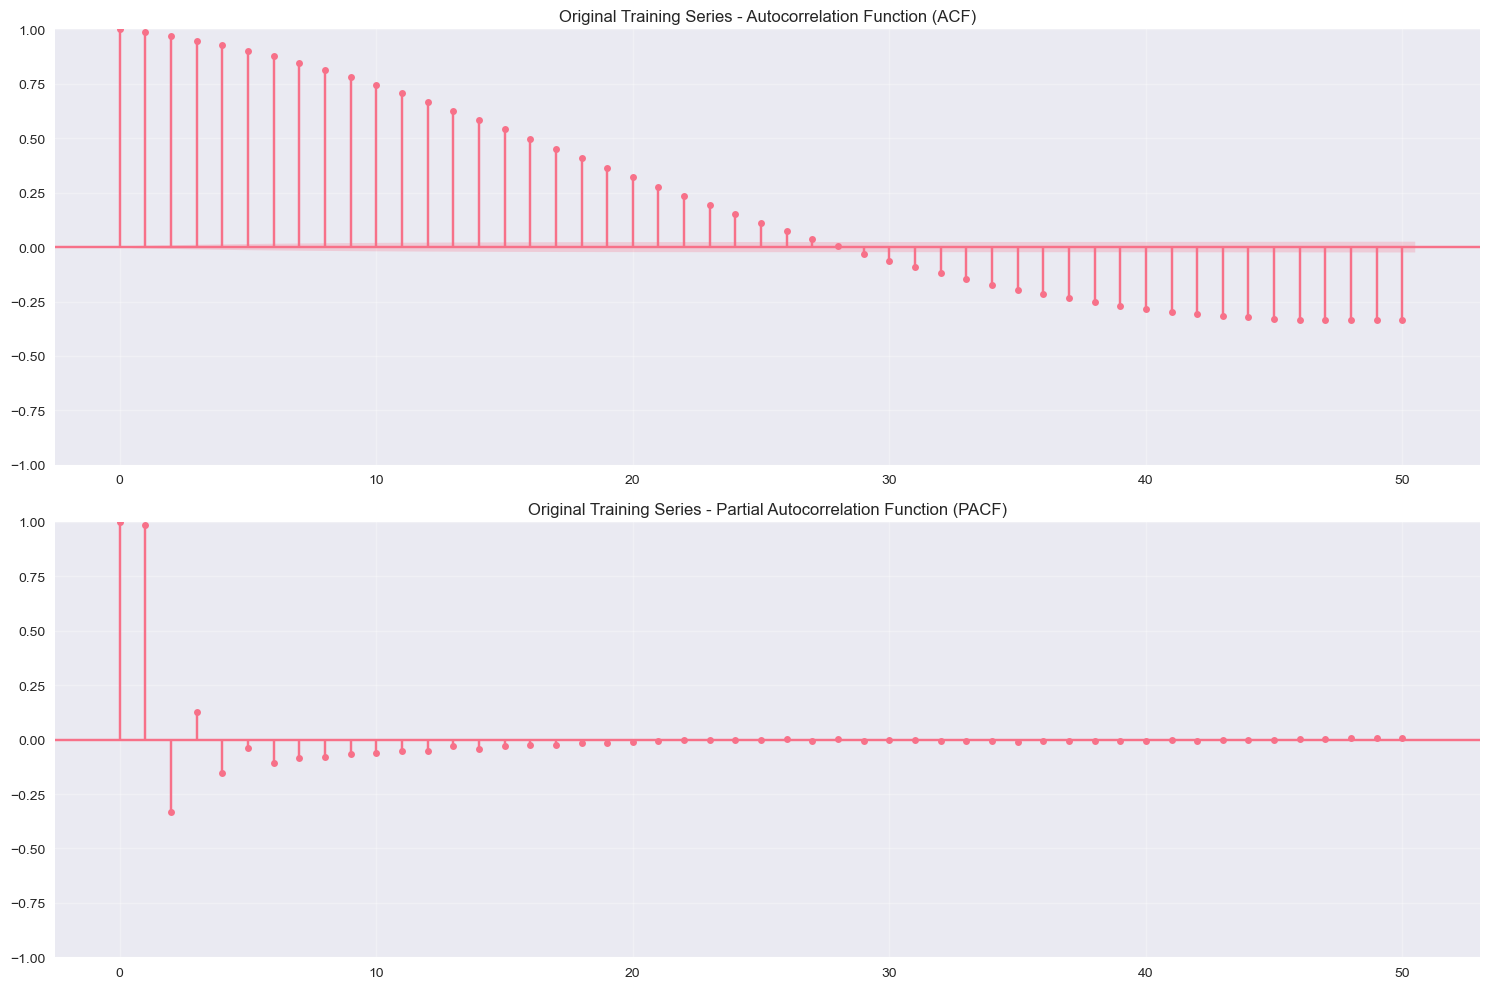


📖 ACF/PACF Interpretation Guide:
🔸 AR(p): PACF cuts off after lag p, ACF decays slowly
🔸 MA(q): ACF cuts off after lag q, PACF decays slowly
🔸 ARMA(p,q): Both ACF and PACF decay slowly
🔸 Seasonal patterns repeat every 96 lags


In [20]:
def plot_acf_pacf_analysis(series, lags=None, title="ACF/PACF Analysis"):
    """Plot ACF and PACF with interpretation guidance"""
    if lags is None:
        lags = min(len(series) // 4, seasonality * 2, 50)
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # ACF
    plot_acf(series.dropna(), ax=axes[0], lags=lags, alpha=0.05)
    axes[0].set_title(f'{title} - Autocorrelation Function (ACF)')
    axes[0].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(series.dropna(), ax=axes[1], lags=lags, alpha=0.05)
    axes[1].set_title(f'{title} - Partial Autocorrelation Function (PACF)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation guidance
    print(f"\n📖 ACF/PACF Interpretation Guide:")
    print("🔸 AR(p): PACF cuts off after lag p, ACF decays slowly")
    print("🔸 MA(q): ACF cuts off after lag q, PACF decays slowly") 
    print("🔸 ARMA(p,q): Both ACF and PACF decay slowly")
    print(f"🔸 Seasonal patterns repeat every {seasonality} lags")

# Analyze original series
plot_acf_pacf_analysis(train_series, title="Original Training Series")

# Analyze differenced series if needed
if not is_stationary and 'train_diff1' in locals():
    plot_acf_pacf_analysis(train_diff1, title="First Differenced Series")

In [21]:
def fit_sarima_model(series, order=(1,1,1), seasonal_order=(1,1,1,24), 
                     enforce_stationarity=False, enforce_invertibility=False):
    """Fit SARIMA model with comprehensive error handling"""
    
    print(f"\n🔧 Fitting SARIMA{order} × {seasonal_order}...")
    
    try:
        model = SARIMAX(
            series,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=enforce_stationarity,
            enforce_invertibility=enforce_invertibility
        )
        
        results = model.fit(disp=False, maxiter=200, method='lbfgs')
        
        print(f"SARIMA model fitted successfully")
        print(f"   AIC: {results.aic:.2f}")
        print(f"   BIC: {results.bic:.2f}")
        print(f"   Log-likelihood: {results.llf:.2f}")
        
        return results
        
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None

def auto_sarima_selection(series, seasonal_period):
    """Automatic SARIMA model selection using pmdarima"""
    if not AUTO_ARIMA_AVAILABLE:
        print("pmdarima not available. Using default parameters.")
        return fit_sarima_model(series, seasonal_order=(1,1,1,seasonal_period))
    
    print("Running automatic SARIMA model selection...")
    
    try:
        auto_model = auto_arima(
            series,
            seasonal=True,
            m=seasonal_period,
            max_p=3, max_q=3, max_P=2, max_Q=2,
            max_d=2, max_D=1,
            start_p=0, start_q=0,
            start_P=0, start_Q=0,
            information_criterion='aic',
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=True
        )
        
        print(f"Best model found: SARIMA{auto_model.order} × {auto_model.seasonal_order}")
        print(f"   AIC: {auto_model.aic():.2f}")
        
        return auto_model
        
    except Exception as e:
        print(f"Auto ARIMA failed: {e}")
        print("Falling back to manual selection...")
        return fit_sarima_model(series, seasonal_order=(1,1,1,seasonal_period))

In [ ]:
# Try automatic model selection first
print("SARIMA Model Selection")
print("=" * 40)

sarima_model = auto_sarima_selection(train_series, seasonality)

# If auto selection failed, try manual selection
if sarima_model is None:
    print("\nTrying manual SARIMA parameter selection...")
    
    # Based on stationarity analysis, choose appropriate parameters
    d = 0 if is_stationary else 1
    D = 1  # Usually 1 for seasonal data
    
    # Try several combinations
    param_combinations = [
        ((1, d, 1), (1, D, 1, seasonality)),
        ((2, d, 1), (1, D, 1, seasonality)),
        ((1, d, 2), (1, D, 1, seasonality)),
        ((2, d, 2), (1, D, 1, seasonality)),
        ((1, d, 1), (2, D, 1, seasonality)),
    ]
    
    best_aic = float('inf')
    best_model = None
    
    for order, seasonal_order in param_combinations:
        model = fit_sarima_model(train_series, order, seasonal_order)
        if model is not None:
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                print(f"   New best model: SARIMA{order} × {seasonal_order}, AIC: {model.aic:.2f}")
    
    sarima_model = best_model

# Display model summary
if sarima_model is not None:
    print(f"\nFinal SARIMA Model Summary:")
    print(sarima_model.summary())
else:
    print("Could not fit any SARIMA model")

SARIMA Model Selection
🤖 Running automatic SARIMA model selection...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=1114862.763, Time=1.17 sec


In [ ]:
def perform_residual_diagnostics(model_results, model_name, plot_size=(15, 12)):
    """Comprehensive residual analysis"""
    
    print(f"\n🔍 Residual Diagnostics for {model_name}")
    print("=" * 50)
    
    try:
        # Plot diagnostics
        fig = model_results.plot_diagnostics(figsize=plot_size)
        plt.suptitle(f'{model_name} Residual Diagnostics', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Extract residuals
        residuals = model_results.resid.dropna()
        
        # Ljung-Box test for autocorrelation
        lags_to_test = [10, 20, min(len(residuals)//4, 40)]
        lb_results = acorr_ljungbox(residuals, lags=lags_to_test, return_df=True)
        
        print("Ljung-Box Test Results (testing for autocorrelation):")
        print(lb_results)
        print("✅ Good: p-values > 0.05 (no significant autocorrelation)")
        print("❌ Concerning: p-values ≤ 0.05 (autocorrelation present)")
        
        # Normality test
        from scipy import stats
        _, p_value_normality = stats.jarque_bera(residuals)
        print(f"\nJarque-Bera Normality Test:")
        print(f"p-value: {p_value_normality:.6f}")
        if p_value_normality > 0.05:
            print("✅ Residuals appear normally distributed")
        else:
            print("⚠️ Residuals may not be normally distributed")
            
        # Summary statistics
        print(f"\nResidual Summary Statistics:")
        print(f"Mean: {residuals.mean():.6f} (should be close to 0)")
        print(f"Std: {residuals.std():.6f}")
        print(f"Skewness: {residuals.skew():.6f}")
        print(f"Kurtosis: {residuals.kurtosis():.6f}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error in diagnostics: {e}")
        return False

# Perform diagnostics if model was fitted successfully
if sarima_model is not None:
    perform_residual_diagnostics(sarima_model, "SARIMA")

In [ ]:
def fit_ets_model(series, seasonal_periods, error="add", trend="add", 
                  seasonal="add", damped_trend=True):
    """Fit ETS model with error handling"""
    
    model_string = f"ETS({error[0].upper()},{trend[0].upper()}"
    if seasonal != "add":
        model_string += f",{seasonal[0].upper()})"
    else:
        model_string += ",A)"
    if damped_trend:
        model_string = model_string.replace(")", "d)")
        
    print(f"\n🔧 Fitting {model_string} model...")
    
    try:
        # Ensure series has proper frequency
        if series.index.freq is None:
            freq = pd.infer_freq(series.index)
            if freq:
                series = series.asfreq(freq)
            else:
                print("⚠️ Could not infer frequency, using original series")
        
        model = ETSModel(
            series,
            error=error,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            damped_trend=damped_trend
        )
        
        results = model.fit(disp=False)
        
        print(f"✅ ETS model fitted successfully")
        print(f"   AIC: {results.aic:.2f}")
        print(f"   BIC: {results.bic:.2f}")
        print(f"   Log-likelihood: {results.llf:.2f}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error fitting ETS model: {e}")
        return None

def select_best_ets_model(series, seasonal_periods):
    """Try different ETS configurations and select the best one"""
    
    print("🎯 ETS Model Selection")
    print("=" * 30)
    
    # Define model configurations to try
    configurations = [
        ("add", "add", "add", True),    # ETS(A,Ad,A)
        ("add", "add", "add", False),   # ETS(A,A,A)
        ("add", "add", "mul", True),    # ETS(A,Ad,M)
        ("add", "add", "mul", False),   # ETS(A,A,M)
        ("add", None, "add", False),    # ETS(A,N,A)
        ("add", None, "mul", False),    # ETS(A,N,M)
        ("mul", "add", "mul", True),    # ETS(M,Ad,M)
        ("mul", "add", "mul", False),   # ETS(M,A,M)
    ]
    
    best_aic = float('inf')
    best_model = None
    best_config = None
    
    for error, trend, seasonal, damped in configurations:
        # Skip multiplicative models if series has zeros or negative values
        if error == "mul" or seasonal == "mul":
            if (series <= 0).any():
                continue
                
        model = fit_ets_model(series, seasonal_periods, error, trend, seasonal, damped)
        
        if model is not None and model.aic < best_aic:
            best_aic = model.aic
            best_model = model
            best_config = (error, trend, seasonal, damped)
            
    if best_model is not None:
        print(f"\n🏆 Best ETS Model: {best_config}")
        print(f"   AIC: {best_aic:.2f}")
    
    return best_model

# Fit ETS model
ets_model = select_best_ets_model(train_series, seasonality)

# Display model summary
if ets_model is not None:
    print(f"\n📊 ETS Model Summary:")
    print(ets_model.summary())
    
    # Perform diagnostics
    perform_residual_diagnostics(ets_model, "ETS")
else:
    print("❌ Could not fit any ETS model")

In [ ]:
def create_baseline_models(train_series, test_series, seasonal_period):
    """Create naive baseline models for comparison"""
    
    print("\n🎯 Creating Baseline Models")
    print("=" * 35)
    
    baselines = {}
    
    # 1. Naive (Random Walk) - last value carries forward
    naive_pred = pd.Series(
        [train_series.iloc[-1]] * len(test_series),
        index=test_series.index,
        name='Naive'
    )
    baselines['Naive'] = naive_pred
    print("✅ Naive model created")
    
    # 2. Seasonal Naive - same time from previous season
    if len(train_series) >= seasonal_period:
        seasonal_naive_values = []
        for i in range(len(test_series)):
            # Get the value from the same position in the previous season
            seasonal_lag_idx = -(seasonal_period - (i % seasonal_period))
            if abs(seasonal_lag_idx) <= len(train_series):
                seasonal_naive_values.append(train_series.iloc[seasonal_lag_idx])
            else:
                # If not enough history, use the last available value
                seasonal_naive_values.append(train_series.iloc[-1])
        
        seasonal_naive_pred = pd.Series(
            seasonal_naive_values,
            index=test_series.index,
            name='Seasonal_Naive'
        )
        baselines['Seasonal_Naive'] = seasonal_naive_pred
        print("✅ Seasonal Naive model created")
    
    # 3. Linear Trend - simple linear extrapolation
    try:
        from scipy import stats
        
        # Fit linear trend to last portion of training data
        trend_window = min(len(train_series), seasonal_period * 4)
        recent_data = train_series[-trend_window:]
        x_trend = np.arange(len(recent_data))
        slope, intercept, _, _, _ = stats.linregress(x_trend, recent_data.values)
        
        # Project trend forward
        trend_pred_values = []
        for i in range(len(test_series)):
            trend_value = intercept + slope * (len(recent_data) + i)
            trend_pred_values.append(trend_value)
        
        trend_pred = pd.Series(
            trend_pred_values,
            index=test_series.index,
            name='Linear_Trend'
        )
        baselines['Linear_Trend'] = trend_pred
        print("✅ Linear Trend model created")
        
    except Exception as e:
        print(f"⚠️ Could not create Linear Trend model: {e}")
    
    # 4. Moving Average
    ma_window = min(seasonal_period, len(train_series) // 4)
    ma_value = train_series[-ma_window:].mean()
    
    ma_pred = pd.Series(
        [ma_value] * len(test_series),
        index=test_series.index,
        name='Moving_Average'
    )
    baselines['Moving_Average'] = ma_pred
    print("✅ Moving Average model created")
    
    return baselines

# Create baseline models
baseline_predictions = create_baseline_models(train_series, test_series, seasonality)

In [ ]:
def calculate_metrics(actual, predicted, model_name):
    """Calculate comprehensive evaluation metrics"""
    
    # Ensure no NaN values
    mask = ~(pd.isna(actual) | pd.isna(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        print(f"⚠️ No valid data points for {model_name}")
        return None
    
    # Basic metrics
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    
    # R-squared
    r2 = r2_score(actual_clean, predicted_clean)
    
    # MAPE variants (handling division by zero)
    epsilon = 1e-8
    
    # Standard MAPE (capped at 100% for extreme outliers)
    mape = np.mean(np.clip(
        np.abs((actual_clean - predicted_clean) / (np.abs(actual_clean) + epsilon)), 
        0, 1.0
    )) * 100
    
    # Symmetric MAPE
    smape = np.mean(
        2 * np.abs(actual_clean - predicted_clean) / 
        (np.abs(actual_clean) + np.abs(predicted_clean) + epsilon)
    ) * 100
    
    # Mean Absolute Scaled Error (MASE) - requires seasonal naive benchmark
    try:
        if len(actual_clean) > seasonality:
            naive_errors = np.abs(actual_clean[seasonality:] - actual_clean[:-seasonality])
            mae_naive = np.mean(naive_errors)
            mase = mae / (mae_naive + epsilon)
        else:
            mase = np.nan
    except:
        mase = np.nan
    
    # Additional metrics
    bias = np.mean(predicted_clean - actual_clean)
    max_error = np.max(np.abs(actual_clean - predicted_clean))
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'sMAPE': smape,
        'MASE': mase,
        'R²': r2,
        'Bias': bias,
        'Max_Error': max_error,
        'N_Points': len(actual_clean)
    }
    
    return metrics

def create_metrics_summary(all_predictions, actual_values):
    """Create comprehensive metrics summary table"""
    
    print("\n📊 Model Performance Evaluation")
    print("=" * 50)
    
    metrics_list = []
    
    for model_name, predictions in all_predictions.items():
        metrics = calculate_metrics(actual_values, predictions, model_name)
        if metrics:
            metrics_list.append(metrics)
            
            # Print individual results
            print(f"\n{model_name}:")
            print(f"  MAE:     {metrics['MAE']:.4f}")
            print(f"  RMSE:    {metrics['RMSE']:.4f}")
            print(f"  MAPE:    {metrics['MAPE']:.2f}%")
            print(f"  R²:      {metrics['R²']:.4f}")
    
    # Create summary DataFrame
    if metrics_list:
        metrics_df = pd.DataFrame(metrics_list)
        
        # Sort by RMSE (lower is better)
        metrics_df = metrics_df.sort_values('RMSE')
        
        print(f"\n🏆 Model Rankings (by RMSE):")
        print("=" * 70)
        print(metrics_df[['Model', 'MAE', 'RMSE', 'MAPE', 'R²']].round(4))
        
        return metrics_df
    else:
        print("❌ No valid metrics calculated")
        return None

In [ ]:
# Collect all predictions
all_predictions = {}

# SARIMA predictions
if sarima_model is not None:
    try:
        print("\n🔮 Generating SARIMA predictions...")
        sarima_forecast = sarima_model.forecast(steps=len(test_series))
        sarima_forecast.index = test_series.index
        all_predictions['SARIMA'] = sarima_forecast
        print("✅ SARIMA predictions generated")
    except Exception as e:
        print(f"❌ Error generating SARIMA predictions: {e}")

# ETS predictions
if ets_model is not None:
    try:
        print("🔮 Generating ETS predictions...")
        ets_forecast = ets_model.forecast(steps=len(test_series))
        ets_forecast.index = test_series.index
        all_predictions['ETS'] = ets_forecast
        print("✅ ETS predictions generated")
    except Exception as e:
        print(f"❌ Error generating ETS predictions: {e}")

# Add baseline predictions
all_predictions.update(baseline_predictions)

# Calculate comprehensive metrics
metrics_summary = create_metrics_summary(all_predictions, test_series)

In [ ]:
def diebold_mariano_test(actual, pred1, pred2, h=1):
    """
    Diebold-Mariano test for comparing forecast accuracy
    H0: Both models have equal predictive accuracy
    H1: Model 1 has different predictive accuracy than Model 2
    """
    try:
        from scipy import stats
        
        # Calculate squared errors
        e1 = (actual - pred1) ** 2
        e2 = (actual - pred2) ** 2
        
        # Difference in squared errors
        d = e1 - e2
        
        # Mean of differences
        mean_d = np.mean(d)
        
        # Variance of differences (with Newey-West correction for autocorrelation)
        n = len(d)
        gamma0 = np.var(d, ddof=1)
        
        # Simple variance (not accounting for autocorrelation)
        var_d = gamma0 / n
        
        # DM statistic
        dm_stat = mean_d / np.sqrt(var_d)
        
        # P-value (two-tailed)
        p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
        
        return dm_stat, p_value
        
    except Exception as e:
        print(f"Error in DM test: {e}")
        return None, None

# Perform pairwise comparisons of top models
if metrics_summary is not None and len(metrics_summary) >= 2:
    print("\n🔬 Statistical Significance Testing (Diebold-Mariano)")
    print("=" * 60)
    
    top_models = metrics_summary.head(3)['Model'].values
    
    for i in range(len(top_models)):
        for j in range(i+1, len(top_models)):
            model1, model2 = top_models[i], top_models[j]
            
            if model1 in all_predictions and model2 in all_predictions:
                dm_stat, p_value = diebold_mariano_test(
                    test_series,
                    all_predictions[model1],
                    all_predictions[model2]
                )
                
                if dm_stat is not None:
                    significance = "Significant" if p_value < 0.05 else "Not Significant"
                    better_model = model1 if dm_stat < 0 else model2
                    
                    print(f"\n{model1} vs {model2}:")
                    print(f"  DM Statistic: {dm_stat:.4f}")
                    print(f"  p-value: {p_value:.4f}")
                    print(f"  Result: {significance}")
                    if p_value < 0.05:
                        print(f"  Better Model: {better_model}")

In [ ]:
def plot_forecast_comparison(train_data, test_data, predictions_dict, 
                           title="Model Comparison", figsize=(18, 10)):
    """Create comprehensive forecast comparison visualization"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Define colors for consistent plotting
    colors = plt.cm.Set3(np.linspace(0, 1, len(predictions_dict)))
    
    # Plot 1: Full comparison
    ax1 = axes[0, 0]
    
    # Show last portion of training data for context
    context_points = min(len(train_data), seasonality * 3)
    ax1.plot(train_data.index[-context_points:], train_data.iloc[-context_points:], 
             label='Training (last portion)', color='gray', alpha=0.6, linewidth=1)
    
    # Plot actual test data
    ax1.plot(test_data.index, test_data, label='Actual', 
             color='black', linewidth=2, marker='o', markersize=2)
    
    # Plot predictions
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        ax1.plot(pred.index, pred, label=model_name, 
                color=colors[i], linewidth=1.5, alpha=0.8)
    
    ax1.set_title('Forecast Comparison - Full View')
    ax1.set_ylabel('GHI')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Zoomed view (first part of test period)
    ax2 = axes[0, 1]
    zoom_points = min(len(test_data), seasonality)
    
    ax2.plot(test_data.index[:zoom_points], test_data.iloc[:zoom_points], 
             label='Actual', color='black', linewidth=2, marker='o', markersize=3)
    
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        ax2.plot(pred.index[:zoom_points], pred.iloc[:zoom_points], 
                label=model_name, color=colors[i], linewidth=2, alpha=0.8)
    
    ax2.set_title(f'Forecast Comparison - First {zoom_points} Points')
    ax2.set_ylabel('GHI')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Residuals comparison
    ax3 = axes[1, 0]
    
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        residuals = test_data - pred
        ax3.plot(residuals.index, residuals, label=f'{model_name} Residuals', 
                color=colors[i], alpha=0.7)
    
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Residuals Comparison')
    ax3.set_ylabel('Residual')
    ax3.set_xlabel('Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Residuals distribution
    ax4 = axes[1, 1]
    
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        residuals = test_data - pred
        ax4.hist(residuals, bins=20, alpha=0.6, label=f'{model_name}', 
                color=colors[i], density=True)
    
    ax4.set_title('Residuals Distribution')
    ax4.set_xlabel('Residual Value')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the comparison plot
plot_forecast_comparison(train_series, test_series, all_predictions)

In [ ]:
def plot_error_analysis(test_data, predictions_dict, figsize=(16, 12)):
    """Detailed error analysis visualization"""
    
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    
    # Calculate errors for all models
    errors = {}
    abs_errors = {}
    
    for model_name, pred in predictions_dict.items():
        errors[model_name] = test_data - pred
        abs_errors[model_name] = np.abs(test_data - pred)
    
    # Plot 1: Box plot of absolute errors
    ax1 = axes[0, 0]
    error_data = [abs_errors[model] for model in predictions_dict.keys()]
    bp = ax1.boxplot(error_data, labels=list(predictions_dict.keys()), patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
    
    ax1.set_title('Absolute Errors Distribution')
    ax1.set_ylabel('Absolute Error')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error vs Time
    ax2 = axes[0, 1]
    for i, (model_name, error) in enumerate(errors.items()):
        ax2.plot(error.index, error, alpha=0.7, label=model_name)
    
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Errors Over Time')
    ax2.set_ylabel('Error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Actual vs Predicted scatter plots
    ax3 = axes[1, 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(predictions_dict)))
    
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        ax3.scatter(test_data, pred, alpha=0.6, label=model_name, 
                   color=colors[i], s=20)
    
    # Perfect prediction line
    min_val, max_val = test_data.min(), test_data.max()
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, 
             label='Perfect Prediction')
    
    ax3.set_title('Actual vs Predicted')
    ax3.set_xlabel('Actual GHI')
    ax3.set_ylabel('Predicted GHI')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative absolute errors
    ax4 = axes[1, 1]
    
    for i, (model_name, abs_err) in enumerate(abs_errors.items()):
        cumulative_error = np.cumsum(abs_err)
        ax4.plot(abs_err.index, cumulative_error, label=model_name, 
                color=colors[i], linewidth=2)
    
    ax4.set_title('Cumulative Absolute Errors')
    ax4.set_ylabel('Cumulative Absolute Error')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Error by hour of day (if applicable)
    ax5 = axes[2, 0]
    
    try:
        # Extract hour from index
        hours = test_data.index.hour
        
        for model_name, error in abs_errors.items():
            hourly_errors = []
            for hour in range(24):
                hour_mask = hours == hour
                if hour_mask.any():
                    hourly_errors.append(error[hour_mask].mean())
                else:
                    hourly_errors.append(0)
            
            ax5.plot(range(24), hourly_errors, marker='o', label=model_name)
        
        ax5.set_title('Average Absolute Error by Hour')
        ax5.set_xlabel('Hour of Day')
        ax5.set_ylabel('Average Absolute Error')
        ax5.set_xticks(range(0, 24, 4))
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
    except Exception as e:
        ax5.text(0.5, 0.5, f'Hour analysis not available:\n{str(e)}', 
                transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('Hour Analysis (Not Available)')
    
    # Plot 6: QQ plots for residuals normality
    ax6 = axes[2, 1]
    
    try:
        from scipy import stats
        
        # Show QQ plot for best model only (to avoid clutter)
        if metrics_summary is not None:
            best_model = metrics_summary.iloc[0]['Model']
            if best_model in errors:
                stats.probplot(errors[best_model].dropna(), dist="norm", plot=ax6)
                ax6.set_title(f'QQ Plot - {best_model} Residuals')
                ax6.grid(True, alpha=0.3)
            else:
                ax6.text(0.5, 0.5, 'Best model not found', 
                        transform=ax6.transAxes, ha='center', va='center')
        else:
            ax6.text(0.5, 0.5, 'No metrics available', 
                    transform=ax6.transAxes, ha='center', va='center')
            
    except Exception as e:
        ax6.text(0.5, 0.5, f'QQ plot not available:\n{str(e)}', 
                transform=ax6.transAxes, ha='center', va='center')
        ax6.set_title('QQ Plot (Not Available)')
    
    plt.tight_layout()
    plt.show()

# Create error analysis plots
plot_error_analysis(test_series, all_predictions)

In [ ]:
def create_performance_summary_plots(metrics_df, figsize=(16, 10)):
    """Create summary visualizations of model performance"""
    
    if metrics_df is None or len(metrics_df) == 0:
        print("No metrics data available for visualization")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Sort by RMSE for consistent ordering
    metrics_sorted = metrics_df.sort_values('RMSE')
    models = metrics_sorted['Model']
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    # Plot 1: RMSE Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(models, metrics_sorted['RMSE'], color=colors, alpha=0.8)
    ax1.set_title('Root Mean Squared Error (RMSE)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars1, metrics_sorted['RMSE']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: MAE Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(models, metrics_sorted['MAE'], color=colors, alpha=0.8)
    ax2.set_title('Mean Absolute Error (MAE)')
    ax2.set_ylabel('MAE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars2, metrics_sorted['MAE']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 3: MAPE Comparison
    ax3 = axes[0, 2]
    bars3 = ax3.bar(models, metrics_sorted['MAPE'], color=colors, alpha=0.8)
    ax3.set_title('Mean Absolute Percentage Error (MAPE)')
    ax3.set_ylabel('MAPE (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars3, metrics_sorted['MAPE']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Plot 4: R² Comparison
    ax4 = axes[1, 0]
    bars4 = ax4.bar(models, metrics_sorted['R²'], color=colors, alpha=0.8)
    ax4.set_title('R-squared (R²)')
    ax4.set_ylabel('R²')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim(0, 1)
    
    for bar, value in zip(bars4, metrics_sorted['R²']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 5: Radar chart of normalized metrics
    ax5 = axes[1, 1]
    
    # Normalize metrics (lower is better for RMSE, MAE, MAPE; higher is better for R²)
    metrics_for_radar = metrics_sorted[['RMSE', 'MAE', 'MAPE', 'R²']].copy()
    
    # Normalize to 0-1 scale
    for col in ['RMSE', 'MAE', 'MAPE']:
        metrics_for_radar[col] = 1 - (metrics_for_radar[col] - metrics_for_radar[col].min()) / \
                                 (metrics_for_radar[col].max() - metrics_for_radar[col].min() + 1e-8)
    
    # R² is already 0-1, but higher is better, so keep as is
    
    # Simple scatter plot instead of radar (easier to implement)
    ax5.scatter(metrics_sorted['MAE'], metrics_sorted['RMSE'], 
               c=range(len(models)), cmap='Set3', s=100, alpha=0.7)
    
    for i, model in enumerate(models):
        ax5.annotate(model, (metrics_sorted.iloc[i]['MAE'], metrics_sorted.iloc[i]['RMSE']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax5.set_xlabel('MAE')
    ax5.set_ylabel('RMSE')
    ax5.set_title('MAE vs RMSE Trade-off')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Relative performance (percentage improvement over naive)
    ax6 = axes[1, 2]
    
    try:
        naive_rmse = metrics_df[metrics_df['Model'] == 'Naive']['RMSE'].iloc[0]
        
        relative_improvement = []
        model_names = []
        
        for _, row in metrics_sorted.iterrows():
            if row['Model'] != 'Naive':
                improvement = (naive_rmse - row['RMSE']) / naive_rmse * 100
                relative_improvement.append(improvement)
                model_names.append(row['Model'])
        
        bars6 = ax6.barh(model_names, relative_improvement, 
                        color=colors[1:len(model_names)+1], alpha=0.8)
        ax6.set_title('RMSE Improvement over Naive (%)')
        ax6.set_xlabel('Improvement (%)')
        ax6.grid(True, alpha=0.3, axis='x')
        ax6.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        for bar, value in zip(bars6, relative_improvement):
            ax6.text(value + 0.5 if value >= 0 else value - 0.5, 
                    bar.get_y() + bar.get_height()/2,
                    f'{value:.1f}%', ha='left' if value >= 0 else 'right', 
                    va='center', fontsize=8)
    
    except Exception as e:
        ax6.text(0.5, 0.5, f'Relative improvement\nplot not available:\n{str(e)}', 
                transform=ax6.transAxes, ha='center', va='center')
        ax6.set_title('Relative Improvement (Not Available)')
    
    plt.tight_layout()
    plt.show()

# Create performance summary
create_performance_summary_plots(metrics_summary)